In [1]:
import pdb, math
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (12,12)

In [2]:
H = 300
W = 300

ORIGIN = np.array([0,0,-10])

EPSILON = 0.01

class DetectorSquare():
    def __init__(self, origin, h=100, w=120, z=0):
        self.h, self.w = h, w
        self.r = float(self.w) / self.h
        self.x1, self.x2, self.y1, self.y2, self.z1, self.z2 = -1, 1, -1. / self.r + .25, 1. / self.r + .25, z, -z
        self.xes = np.linspace(self.x1, self.x2, self.w)
        self.yes = np.linspace(self.y1, self.y2, self.h)

# origin is at -5, getector is at 5 placing objects in the middle        
detector = DetectorSquare(ORIGIN, h=H, w=W, z=15)

In [3]:
#rays from origin to corresponsing point on the detector place
rays = np.stack((detector.xes[:,None].repeat(detector.h,axis=1), 
                 detector.yes[:,None].repeat(detector.w,axis=1).transpose(), 
                 np.zeros((detector.w,detector.h))))

In [95]:
%timeit np.zeros((detector.w,detector.h))

14.7 µs ± 256 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [96]:
%timeit detector.xes[:,None].repeat(detector.h,axis=1)

387 µs ± 3.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [97]:
%timeit np.stack((detector.xes[:,None].repeat(detector.h,axis=1), detector.yes[:,None].repeat(detector.w,axis=1).transpose(), np.zeros((detector.w,detector.h))))

866 µs ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
rays1 = np.concatenate([np.array(np.meshgrid(detector.xes, detector.yes)),np.zeros((300,300))[None,:]])

In [99]:
rays.shape

(3, 300, 300)

In [100]:
rays[:,0,0]

array([-1.  , -0.75,  0.  ])

In [101]:
rays1[:,0,0]

array([-1.  , -0.75,  0.  ])

In [17]:
rays = rays1

In [18]:
#unit vectors from origin to detector plane
vectors = rays - ORIGIN[:,None,None]

In [19]:
#starting positions over every vector
current_points = np.tile(ORIGIN[:,None,None],(detector.w,detector.h))

In [20]:
current_points

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[-10, -10, -10, ..., -10, -10, -10],
        [-10, -10, -10, ..., -10, -10, -10],
        [-10, -10, -10, ..., -10, -10, -10],
        ...,
        [-10, -10, -10, ..., -10, -10, -10],
        [-10, -10, -10, ..., -10, -10, -10],
        [-10, -10, -10, ..., -10, -10, -10]]])

In [21]:
#placeholders
energy_map = np.zeros((detector.w,detector.h))
range_map = np.zeros((detector.w,detector.h))

In [29]:
def sphereSDF(p):  return length(p) - 0.2

def normalize(v): return v/np.linalg.norm(np.array(v), axis=0)

# def torch_displance_point_along_vector(rays0, vectors, distances):
#     return rays0 + vectors*distances

def displance_point_along_vector(p0,vector,d):
    return p0 + vector/np.linalg.norm(vector, axis=0)*d

def length(points):
#     pdb.set_trace()
    return np.sqrt(np.sum((points**2),axis=0))
# length = lambda x: np.sqrt((x**2).sum(axis))



In [30]:
sphereSDF(np.array([0,0,-5])[:,None,None])

array([[4.8]])

In [31]:
displance_point_along_vector(np.array([0,0,-5]), [0,0,1],1)

array([ 0.,  0., -4.])

In [32]:
#rays from origin to corresponsing point on the detector place
rays = np.stack((detector.xes[:,None].repeat(detector.h,axis=1), 
                 detector.yes[:,None].repeat(detector.w,axis=1).transpose(), 
                 np.zeros((detector.w,detector.h))))
#unit vectors from origin to detector plane
vectors = rays - ORIGIN[:,None,None]
#starting positions over every vector
current_points = np.tile(ORIGIN[:,None,None],(detector.w,detector.h))
#placeholders
energy_map = np.zeros((detector.w,detector.h))
range_map = np.zeros((detector.w,detector.h))

In [33]:
# vector_normals = (vectors / normalize(vectors))
ORIGIN_TILE = np.tile(ORIGIN[:,None,None],(detector.w,detector.h))
INNER_STEP = 0.001

#handle interaction and reflection
for _ in range(70):
    min_distance = sphereSDF(current_points)
    min_distance = np.where(min_distance>EPSILON, min_distance, INNER_STEP)
#     pdb.set_trace()
    current_points = displance_point_along_vector(ORIGIN_TILE, vectors, range_map+min_distance) 

    range_map  += min_distance
    energy_map += np.where(min_distance>EPSILON, 0, 1)
    
    if min_distance.min()>10: break

In [34]:
energy_map.max()

69.0

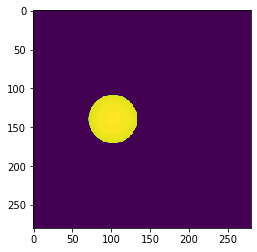

In [35]:
plt.imshow(energy_map[10:-10,10:-10])
plt.show()